In [21]:
import os, getpass
from langchain_openai import ChatOpenAI
from prompts import SYSTEM_PROMPT
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_core.runnables.graph import MermaidDrawMethod
import nest_asyncio

In [22]:
nest_asyncio.apply()
load_dotenv()
# Load environment variables from .env file
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

def display_graph(graph, width=200, height=250):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)
    

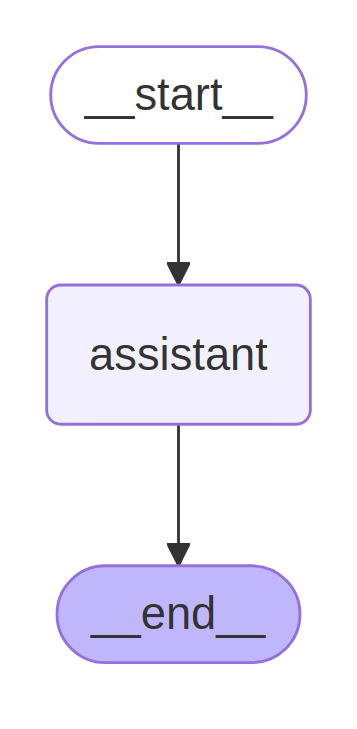

In [23]:
llm = ChatOpenAI(model="gpt-4o")

def assistant(state: MessagesState):
   return {"messages": [llm.invoke([SYSTEM_PROMPT] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

graph = builder.compile()

display_graph(graph)